# Applied Machine Learning: Homework Exercise 07-2

## Goal

The goal of this exercise is to learn how to deal with imbalanced classification problems. This consists of being able to select an appropriate performance metric and learn about methods to adjust the standard machine learning models to improve with respect to that metric.

## Oil spill data

### Data description

The data we will be using in this exercise was first used in the 1998 paper by Miroslav Kubat, et al. named “Machine Learning for the Detection of Oil Spills in Satellite Radar Images.”

The dataset contains a total of 937 observations. Each observation represents a patch of one of nine satellite images and contains information about the patch number and whether an oil spill is present. The rows in the dataset are ordered by image and patch. The data does not contain the original images but extracted numerical features.

### Data dictionary

- V1: The patch number  
- V2 - V49: The features that were extracted from the images by the Canadian Environmental Hazards Detection System (CEHDS)  
- V50: Whether an oil spill is present (encoded as 0) or not (encoded as 1)

### Descriptive analysis and preprocessing

We will first load the data and perform some preprocessing steps. In our modeling approach, we will ignore the spatial correlation between patches and therefore drop the first column, which is the patch number.

We will also rename the target variable to `oilspill` and encode it as a categorical variable with values `"no"` and `"yes"`. Additionally, we will remove two features:

- Feature `V23`, as it is constantly 0
- Feature `V33`, as it has only 4 non-zero values, making it unlikely to be useful for learning

After inspecting the distribution in more detail, we notice the following:

- The target feature `oilspill` is highly imbalanced. There are 896 observations without and only 41 with an oil spill.
- The features are not scaled. Because we will only use tree-based learners in this exercise, this is not a problem.

In [1]:
import pandas as pd
import numpy as np

rng = np.random.default_rng(seed=42)

data_path = "../data/oil_spill.csv"
oil = pd.read_csv(data_path, header=None)

# Rename columns to V1 through V50
column_names = [f"V{i}" for i in range(1, 51)]
oil.columns = column_names

print(f"Column headers:{oil.columns}")

# Drop the first column (spatial patch number) as it's not needed for modeling
oil.drop(columns=['V1'], inplace=True)

# Drop columns V23 and V33
oil.drop(columns=['V23', 'V33'], inplace=True)

# Create a new target variable by mapping V50 to binary values
# 0 -> 'no' (no oil spill), 1 -> 'yes' (oil spill present)
oil['target'] = oil['V50'].map({0: 'no', 1: 'yes'})

X = oil.drop(columns=['V50', 'target'])
y = oil['target']

print(f"Data shape after preprocessing: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")


Column headers:Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31',
       'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41',
       'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50'],
      dtype='object')
Data shape after preprocessing: (937, 46)
Target distribution:
target
no     896
yes     41
Name: count, dtype: int64


## 1 Benchmarking standard algorithms

We will start by comparing two standard machine learning algorithms — a classification tree and a random forest — without taking the imbalanced class distribution into account. Inspecting some standard measures will reveal problems that will be addressed in the subsequent exercises.

Use stratification with respect to the target variable to ensure that each fold in cross-validation maintains the original class distribution.

Then, compare a classification tree with a random forest with respect to their **accuracy**, **false positive rate (FPR)**, and **true positive rate (TPR)**. As a validation strategy, we will use repeated (5 times) 3-fold stratified cross-validation. We only use 3 folds because we have very few positive labels, and we repeat the cross-validation because the dataset is small.

Inspect the results and answer whether accuracy is a good metric for this problem.

### Recap: Stratification

Stratification consists of dividing the population into subsets (called strata) within each of which an independent sample is selected. In scikit-learn, you achieve stratification by using `StratifiedKFold` or `RepeatedStratifiedKFold` as a resampling strategy, which automatically ensures that each fold maintains the original distribution of the classes.

For binary classification problems, the definition of the positive class is important because metrics like the TPR and FPR can only be interpreted correctly when it is clear which class is considered positive. In this exercise, `"yes"` will be treated as the positive class.


<details><summary>Hint 1:</summary>
You can implement repeated stratified cross-validation using `RepeatedStratifiedKFold(n_splits=3, n_repeats=5)`. 
Make sure to define custom scoring functions if you want to compute FPR and TPR.
</details>

In [2]:
#===SOLUTION===

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import recall_score, make_scorer, confusion_matrix


def fpr_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=['no', 'yes'])
    TN = cm[0, 0]
    FP = cm[0, 1]
    return FP / (TN + FP) if (TN + FP) != 0 else 0.0

# Create a scoring dictionary for cross-validation
scoring = {
    'accuracy': 'accuracy',  # overall accuracy
    'TPR': make_scorer(recall_score, pos_label='yes'),  # true positive rate (sensitivity)
    'FPR': make_scorer(fpr_score, greater_is_better=True)  # false positive rate (lower is better)
}

# Set up repeated stratified 3-fold cross-validation (3 folds, 5 repeats)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)

tree = DecisionTreeClassifier(random_state=42)
forest = RandomForestClassifier(random_state=42)

scores_tree = cross_validate(tree, X, y, scoring=scoring, cv=cv, return_train_score=False)
scores_forest = cross_validate(forest, X, y, scoring=scoring, cv=cv, return_train_score=False)

def avg_scores(scores):
    return {metric: np.mean(scores[metric]) for metric in scores if metric.startswith('test_')}

avg_tree = avg_scores(scores_tree)
avg_forest = avg_scores(scores_forest)

print(f"Decision Tree performance:\n"
      f"Accuracy: {avg_tree['test_accuracy']:.6f}, "
      f"FPR: {avg_tree['test_FPR']:.6f}, "
      f"TPR: {avg_tree['test_TPR']:.6f}")

print(f"\nRandom Forest performance:\n"
      f"Accuracy: {avg_forest['test_accuracy']:.6f}, "
      f"FPR: {avg_forest['test_FPR']:.6f}, "
      f"TPR: {avg_forest['test_TPR']:.6f}")


Decision Tree performance:
Accuracy: 0.945995, FPR: 0.029019, TPR: 0.397802

Random Forest performance:
Accuracy: 0.963076, FPR: 0.003125, TPR: 0.224176


Question: Dissuss your observations. Is accuracy a proper metric in this case?

===SOLUTION===

The accuracy is problematic for this task, because it focuses too heavily on the majority class. The FPR and TPR show that, despite the high accuracy, we classify most of the positive instances incorrectly for both models. Interestingly, the simple classification tree has a higher TPR than the - usually superior - random forest.

## 2 Selecting a suitable performance metric

When selecting a suitable performance metric, we have to take the properties of the task into consideration. The detection of a spill requires mobilizing an expensive response, and missing an event is equally expensive, causing damage to the environment. Therefore, both class labels are important.

For that reason, we want to select a measure that is insensitive to changes in the class distribution in the test data. Can you modify the definition of accuracy so that it does not depend on the distribution of the target variable? Compare this new metric with the standard accuracy used in the previous exercise.

<details><summary>Hint 1:</summary>

The standard accuracy can be expressed as:

$$
ACC = P(\hat{Y}=1|Y=1) \cdot P(Y=1) + P(\hat{Y}=0|Y=0) \cdot P(Y=0)
$$

Note that:
- $ TPR = P(\hat{Y}=1|Y=1) $ is the true positive rate.
- $ TNR = P(\hat{Y}=0|Y=0) = 1 - FPR $ is the true negative rate.

This means that accuracy is a **weighted average** of TPR and TNR, where the weights depend on the class distribution $ P(Y=1) $ and $ P(Y=0) $. To remove this dependency, we can equally weight TPR and TNR, leading to the **balanced accuracy**:

$$
BACC = 0.5 \cdot TPR + 0.5 \cdot TNR = 0.5 \cdot TPR + 0.5 \cdot (1 - FPR)
$$

The balanced accuracy is the mean of **sensitivity** (TPR) and **specificity** (TNR).

Compute both the **standard accuracy** and **balanced accuracy** for the classification tree and the random forest models using the same repeated stratified cross-validation as before. Compare the results and reflect on how they differ.

</details>




<details><summary>Hint 1:</summary>
In `scikit-learn`, `balanced_accuracy` is already available as a built-in scoring metric, so you can directly include it in your `scoring` dictionary.
</details>

In [3]:
#===SOLUTION===

# Define scoring dictionary with standard and balanced accuracy
scoring = {
    'acc': 'accuracy',               
    'bal_acc': 'balanced_accuracy' 
}

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)

scores_tree = cross_validate(tree, X, y, scoring=scoring, cv=cv, return_train_score=False)
scores_forest = cross_validate(forest, X, y, scoring=scoring, cv=cv, return_train_score=False)

avg_tree = {metric: np.mean(scores_tree[f'test_{metric}']) for metric in ['acc', 'bal_acc']}
avg_forest = {metric: np.mean(scores_forest[f'test_{metric}']) for metric in ['acc', 'bal_acc']}

print(f"Decision Tree performance:\n"
      f"Standard Accuracy: {avg_tree['acc']:.6f}, Balanced Accuracy: {avg_tree['bal_acc']:.6f}")

print(f"\nRandom Forest performance:\n"
      f"Standard Accuracy: {avg_forest['acc']:.6f}, Balanced Accuracy: {avg_forest['bal_acc']:.6f}")


Decision Tree performance:
Standard Accuracy: 0.945995, Balanced Accuracy: 0.684392

Random Forest performance:
Standard Accuracy: 0.963076, Balanced Accuracy: 0.610526


## 3 Upsampling the minority class

Although we have selected a performance metric (balanced accuracy) that is insensitive to the class distribution in the test data, we still have considerably fewer positive than negative observations in the **training** data. This will make the random forest focus too much on the majority class (no spill).

To address this, we will create a machine learning pipeline that first upsamples the minority class by a factor of two and then fits a random forest. Afterward, we will compare this model to the previous ones with respect to balanced accuracy.

### Recap: Upsampling

Upsampling is a procedure where synthetically generated data points corresponding to the minority class are added to the dataset to reduce the imbalance. In Python, you can implement this conveniently using `imbalanced-learn`'s `RandomOverSampler`.

### Task

- Build a pipeline that:
   - Upsamples the minority class (`yes`) so that it appears twice as often as originally.
   - Trains a random forest on the upsampled data.
- Compare the balanced accuracy of this model to the previous models (decision tree and random forest without upsampling).
- Visualize the results with boxplots.

<details><summary>Hint 1:</summary>
You might encounter and error regarding the suppor for scipy array API. To resolve this, simply set the environment variable `os.environ["SCIPY_ARRAY_API"] = "1"`.
</details>

<details><summary>Hint 2:</summary>
Use `Pipeline` from `imblearn.pipeline` and `RandomOverSampler` from `imblearn.over_sampling` to create the combined upsampling + random forest pipeline.
</details>

Original minority count: 41, Desired minority count: 82


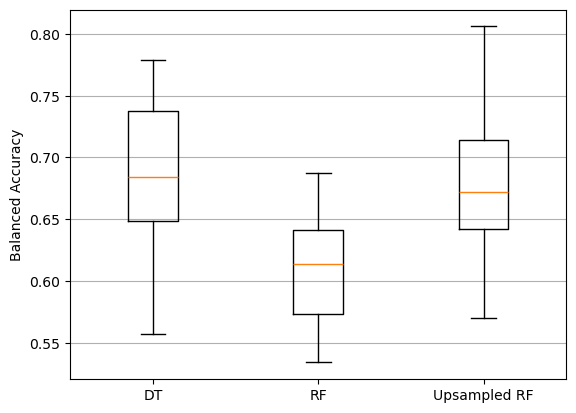

Average balanced accuracy for Decision Tree: 0.684392
Average balanced accuracy for Random Forest: 0.610526
Average balanced accuracy for Upsampled Random Forest: 0.676339


In [4]:
#===SOLUTION===

# Set the environment variable for scipy array API support
import os
os.environ["SCIPY_ARRAY_API"] = "1"

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as imbpipeline
import matplotlib.pyplot as plt

# Compute the desired sampling strategy: double the number of minority class examples.
# Here, we assume the minority class is 'yes'
minority_count = y.value_counts()['yes']
desired_minority_count = int(minority_count * 2)
sampling_strategy = {'yes': desired_minority_count}

print(f"Original minority count: {minority_count}, Desired minority count: {desired_minority_count}")

pipeline = imbpipeline([
    ('oversample', RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)

# Use a dictionary for scoring to ensure consistent key names
scoring = {'score': 'balanced_accuracy'}
scores_pipeline = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, return_train_score=False)
scores_tree_bal = cross_validate(tree, X, y, scoring=scoring, cv=cv, return_train_score=False)
scores_forest_bal = cross_validate(forest, X, y, scoring=scoring, cv=cv, return_train_score=False)

all_scores_dict = pd.DataFrame({
    'Decision Tree': scores_tree_bal['test_score'],
    'Random Forest': scores_forest_bal['test_score'],
    'Upsampled RF': scores_pipeline['test_score']
})

fig, ax = plt.subplots()
ax.boxplot([all_scores_dict['Decision Tree'], all_scores_dict['Random Forest'], all_scores_dict['Upsampled RF']], 
           labels=['DT', 'RF', 'Upsampled RF'])
ax.set_ylabel('Balanced Accuracy')
ax.grid(axis='y')
plt.show()

avg_dt = all_scores_dict['Decision Tree'].mean()
avg_rf = all_scores_dict['Random Forest'].mean()
avg_upsampled = all_scores_dict['Upsampled RF'].mean()

print(f"Average balanced accuracy for Decision Tree: {avg_dt:.6f}")
print(f"Average balanced accuracy for Random Forest: {avg_rf:.6f}")
print(f"Average balanced accuracy for Upsampled Random Forest: {avg_upsampled:.6f}")

Question: did the upsampling approach work?

===SOLUTION===

Although the upsampling approach is superior to the vanilla random forest, there is still room for improvement

## 4 Additional downsampling of the majority class

Repeat the previous experiment, but now not only upsample the minority class, as in the previous exercise, but also **downsample** the majority class so that it matches the count of the upsampled minority class.

### Recap: Downsampling

Downsampling is a mechanism that reduces the number of training samples in the majority class. By combining both upsampling and downsampling, we balance the dataset more effectively, which can help the model better focus on both classes equally.

### Task

- Create a pipeline that:
   - First upsamples the minority class (`yes`) to double its original size.
   - Then downsamples all classes so that both classes have exactly the same number of instances.
   - Finally, fits a random forest.
- Compare this model to the previous models in terms of **balanced accuracy**.


<details><summary>Hint 1:</summary>
Use `RandomOverSampler` and `RandomUnderSampler` from `imblearn` to combine both upsampling and downsampling steps inside a single pipeline.
</details>

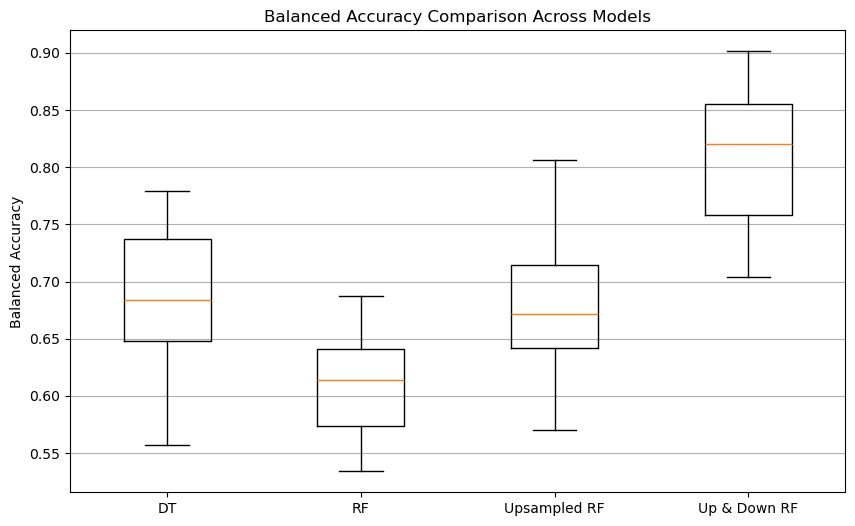

Average balanced accuracy for Decision Tree: 0.684392
Average balanced accuracy for Random Forest: 0.610526
Average balanced accuracy for Upsampled Random Forest: 0.676339
Average balanced accuracy for Up & Down-sampled Random Forest: 0.810536


In [5]:
#===SOLUTION===

from imblearn.under_sampling import RandomUnderSampler


# Create a pipeline that first upsamples the minority class and then downsamples all classes.
pipeline_up_down = imbpipeline([
    ('oversample', RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)),
    ('undersample', RandomUnderSampler(sampling_strategy='all', random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

scoring = {'score': 'balanced_accuracy'}

scores_pipeline_up_down = cross_validate(
    pipeline_up_down, X, y,
    scoring=scoring, cv=cv,
    return_train_score=False
)

all_scores_dict = {
    'Decision Tree': scores_tree_bal['test_score'],
    'Random Forest': scores_forest_bal['test_score'],
    'Upsampled RF': scores_pipeline['test_score'],
    'Up & Down-sampled RF': scores_pipeline_up_down['test_score']
}

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot([all_scores_dict['Decision Tree'], all_scores_dict['Random Forest'], 
            all_scores_dict['Upsampled RF'], all_scores_dict['Up & Down-sampled RF']], 
           labels=['DT', 'RF', 'Upsampled RF', 'Up & Down RF'])
ax.set_ylabel('Balanced Accuracy')
ax.set_title('Balanced Accuracy Comparison Across Models')
ax.grid(axis='y')
plt.show()

avg_dt = all_scores_dict['Decision Tree'].mean()
avg_rf = all_scores_dict['Random Forest'].mean()
avg_upsampled = all_scores_dict['Upsampled RF'].mean()
avg_updown = all_scores_dict['Up & Down-sampled RF'].mean()

print(f"Average balanced accuracy for Decision Tree: {avg_dt:.6f}")
print(f"Average balanced accuracy for Random Forest: {avg_rf:.6f}")
print(f"Average balanced accuracy for Upsampled Random Forest: {avg_upsampled:.6f}")
print(f"Average balanced accuracy for Up & Down-sampled Random Forest: {avg_updown:.6f}")

Question: did additional downsampling of the majority class work?

===SOLUTION===

Additional downsampling of the majority class improved the result even further and is our best model so far.

## 5 Instance-specific weights

Add another logistic learner to the benchmark that uses instance-specific weights, assigning each observation in the minorty class double the weight compared to the majority class. Further, add a simple logistic regression learner to assess the additional performance difference due to instance-specific weights.

<details><summary>Hint 1:</summary>

`LogisticRegression` specifies the class-wise weights through the argument `class_weight: Dict[str, float]` .

</details>

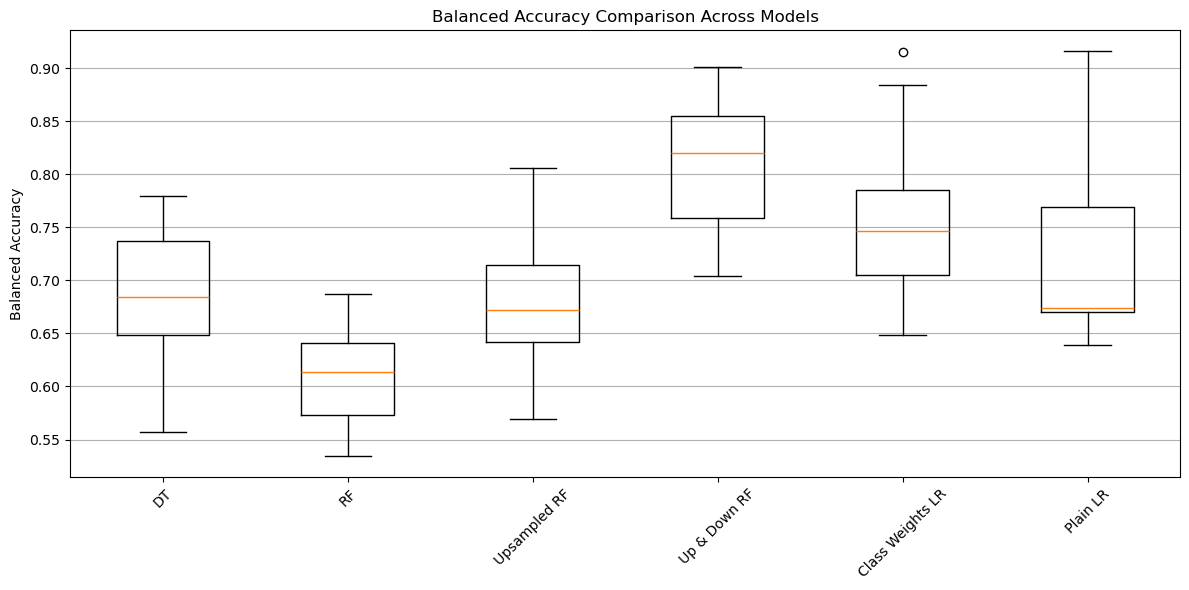

Average balanced accuracy for Decision Tree: 0.684392
Average balanced accuracy for Random Forest: 0.610526
Average balanced accuracy for Upsampled Random Forest: 0.676339
Average balanced accuracy for Up & Down-sampled Random Forest: 0.810536
Average balanced accuracy for Class Weights Logistic Regression: 0.761984
Average balanced accuracy for Plain Logistic Regression: 0.716644


In [6]:
#===SOLUTION===

from sklearn.linear_model import LogisticRegression

# Calculate class weights: minority class gets 2x weight relative to majority
class_weight = {'no': 1, 'yes': 2}

logreg_weighted = LogisticRegression(
    class_weight=class_weight, 
    random_state=42,
    max_iter=5000,  
    solver='liblinear' 
)

scores_logreg_weighted = cross_validate(
    logreg_weighted, X, y,
    scoring=scoring, cv=cv,
    return_train_score=False
)

# Plain Logistic Regression (no class weights)
logreg_plain = LogisticRegression(
    random_state=42,
    max_iter=5000,  
    solver='liblinear' 
)

scores_logreg_plain = cross_validate(
    logreg_plain, X, y,
    scoring=scoring, cv=cv,
    return_train_score=False
)

all_scores_dict = {
    'DT': scores_tree_bal['test_score'],
    'RF': scores_forest_bal['test_score'],
    'Upsampled RF': scores_pipeline['test_score'],
    'Up & Down-sampled RF': scores_pipeline_up_down['test_score'],
    'Class Weights LR': scores_logreg_weighted['test_score'],
    'Plain LR': scores_logreg_plain['test_score']
}

# Updated Visualization with all 6 models
fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot([
    all_scores_dict['DT'], 
    all_scores_dict['RF'], 
    all_scores_dict['Upsampled RF'], 
    all_scores_dict['Up & Down-sampled RF'],
    all_scores_dict['Class Weights LR'],
    all_scores_dict['Plain LR']
], 
labels=['DT', 'RF', 'Upsampled RF', 'Up & Down RF', 'Class Weights LR', 'Plain LR'])
ax.set_ylabel('Balanced Accuracy')
ax.set_title('Balanced Accuracy Comparison Across Models')
ax.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Updated average calculations
avg_dt = all_scores_dict['DT'].mean()
avg_rf = all_scores_dict['RF'].mean()
avg_upsampled = all_scores_dict['Upsampled RF'].mean()
avg_updown = all_scores_dict['Up & Down-sampled RF'].mean()
avg_weighted_lr = all_scores_dict['Class Weights LR'].mean()
avg_plain_lr = all_scores_dict['Plain LR'].mean()

print(f"Average balanced accuracy for Decision Tree: {avg_dt:.6f}")
print(f"Average balanced accuracy for Random Forest: {avg_rf:.6f}")
print(f"Average balanced accuracy for Upsampled Random Forest: {avg_upsampled:.6f}")
print(f"Average balanced accuracy for Up & Down-sampled Random Forest: {avg_updown:.6f}")
print(f"Average balanced accuracy for Class Weights Logistic Regression: {avg_weighted_lr:.6f}")
print(f"Average balanced accuracy for Plain Logistic Regression: {avg_plain_lr:.6f}")

Question: What is your observation?

===SOLUTION===

While not as good as a combination of up- and down-sampling, using instance-specific weights improved the performance of logistic regression.

## Bonus exercise: Tuning the sampling rate

In the previous exercise, we set the upsampling ratio to `2`. Now, investigate whether tuning this value improves the model's performance. To do so, construct a **hyperparameter tuning** procedure with an inner 3-fold cross-validation and a grid search over a suitable range of ratios.

The goal is to find the best upsampling factor for the minority class, rather than fixing it arbitrarily.

### Task

- Set up a pipeline that:
    - Upsamples the minority class using a tunable ratio.
    - Downsamples the majority class to balance the classes after upsampling.
    - Fits a random forest.
- Tune the **upsampling ratio** hyperparameter by using a grid search with 3-fold inner cross-validation.
- Evaluate the tuned model with repeated stratified 3-fold cross-validation (same as used previously).
- Compare the tuned model against the earlier models by inspecting the **balanced accuracy**.


<details><summary>Hint 1:</summary>
You can create a custom subclass of `RandomOverSampler`, which has tunable parameter `ratio` determining the upsampling ratio for the minor class. This class also instantiates a sampling strategy based on the `ratio` hyperparameter and pass the sampling strategy to its superclass. Next, you use `GridSearchCV` to tune the `ratio` parameter indirectly by treating the ratio as a hyperparameter.
</details>

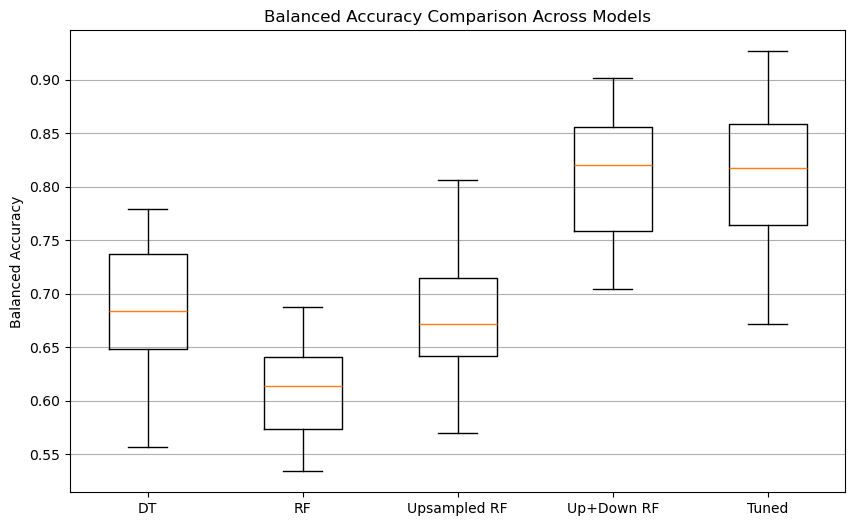

Average balanced accuracy for Tuned Pipeline: 0.812785


In [7]:
#===SOLUTION===

from sklearn.model_selection import GridSearchCV

class CustomRandomOverSampler(RandomOverSampler):
    """
    This class allows for a tunable ratio of upsampling the minority class.
    """
    def __init__(self, ratio=2.0, random_state=None, **kwargs):
        self.ratio = ratio
        super().__init__(sampling_strategy=self._sampling_strategy_func, random_state=random_state, **kwargs)
    
    def _sampling_strategy_func(self, y):
        # Compute class counts
        unique, counts = np.unique(y, return_counts=True)
        count_dict = dict(zip(unique, counts))
        # If the minority class ('yes') is not present, return empty dict.
        if 'yes' not in count_dict:
            return {}
        # Set the desired number for the minority class to be ratio * its original count.
        return {'yes': int(self.ratio * count_dict['yes'])}

pipeline_tuned = imbpipeline([
    ('oversample', CustomRandomOverSampler(ratio=2.0, random_state=42)),
    ('undersample', RandomUnderSampler(sampling_strategy='all', random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'oversample__ratio': [1, 2, 3, 4, 5, 6]
}

grid_search = GridSearchCV(estimator=pipeline_tuned, param_grid=param_grid,
                           scoring='balanced_accuracy', cv=3, n_jobs=-1)

scores_tuned = cross_validate(grid_search, X, y, scoring='balanced_accuracy', cv=cv,
                              return_train_score=False)

all_scores_dict['Tuned Pipeline'] = scores_tuned['test_score']

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot([all_scores_dict['DT'], all_scores_dict['RF'], 
            all_scores_dict['Upsampled RF'], all_scores_dict['Up & Down-sampled RF'],
            all_scores_dict['Tuned Pipeline']], 
           labels=['DT', 'RF', 'Upsampled RF', 'Up+Down RF', 'Tuned'])
ax.set_ylabel('Balanced Accuracy')
ax.set_title('Balanced Accuracy Comparison Across Models')
ax.grid(axis='y')
plt.show()

avg_tuned = scores_tuned['test_score'].mean()
print(f"Average balanced accuracy for Tuned Pipeline: {avg_tuned:.6f}")

Question: did the tuning work?

===SOLUTION===

There is no (real) improvement in tuning, so a ratio of 2 seems like a reasonable choice.

## Summary

In this exercise we addressed the problem of imbalanced class distribution in classification problems. We have seen that standard metrics like accuracy can be misleading for such problems and learned how it can be modified to obtain a balanced accuracy. We then learned how to change the training distribution - using up- and downsampling - to improve the results. Finally, we got a better understanding of the importance of using stratification when having only very few positive labels.